In [2]:
# -------------------------------------------
# 1. 라이브러리 임포트
# -------------------------------------------
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import coint

try:
    from pykalman import KalmanFilter
except ImportError:
    print("error")
    KalmanFilter = None

# Matplotlib 스타일 및 한글 폰트 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'AppleGothic' # Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
print("라이브러리 준비 완료")

라이브러리 준비 완료


In [9]:
# -------------------------------------------
# 2. 데이터 수집 및 준비
# -------------------------------------------
clusters_dict = {
    0: ['Nikkei 225', 'Taiwan', 'S&P 500', 'Dow Jones', 'NASDAQ', 'S&P/TSX', 'FTSE 100', 'DAX', 'CAC 40', 'EURO STOXX 50'],
    1: ['KOSPI', 'Shanghai', 'Hang Seng']
}

indices_tickers = {
    'KOSPI': 'KS11', 'Nikkei 225': 'N225', 'Shanghai': 'SSEC', 'Hang Seng': 'HSI', 'Taiwan': '^TWII',
    'S&P 500': 'US500', 'Dow Jones': 'DJI', 'NASDAQ': 'IXIC', 'S&P/TSX': '^GSPTSE',
    'FTSE 100': 'FTSE', 'DAX': 'GDAXI', 'CAC 40': 'FCHI', 'EURO STOXX 50': '^STOXX50E'
}

start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')


all_indices_in_clusters = [name for cluster in clusters_dict.values() for name in cluster]
all_tickers_to_fetch = {name: ticker for name, ticker in indices_tickers.items() if name in all_indices_in_clusters}

print(f"📈 총 {len(all_tickers_to_fetch)}개 지수의 데이터를 수집합니다 ({start_date} ~ {end_date})...")

prices_df = pd.DataFrame()
for name, ticker in all_tickers_to_fetch.items():
    try:
        stock_data = fdr.DataReader(ticker, start_date, end_date)['Close']
        prices_df[name] = stock_data
    except Exception as e:
        print(f"  - {name} ({ticker}) 데이터 수집 실패: {e}")

prices_df.dropna(inplace=True)
print("데이터 수집 및 준비 완료")

📈 총 13개 지수의 데이터를 수집합니다 (2023-01-01 ~ 2025-08-30)...
데이터 수집 및 준비 완료


In [11]:
# -------------------------------------------
# 3. 같은 클러스터 내 페어 탐색
# -------------------------------------------
def find_intra_cluster_pairs(data, tickers_list, threshold=0.05):
    pairs = []
    for i in range(len(tickers_list)):
        for j in range(i + 1, len(tickers_list)):
            S1 = data.get(tickers_list[i])
            S2 = data.get(tickers_list[j])
            if S1 is None or S2 is None or len(S1) < 50:
                continue
            
            _, pvalue, _ = coint(S1, S2)
            if pvalue < threshold: 
                pairs.append((tickers_list[i], tickers_list[j], pvalue))
    return pairs

print("\n--- 같은 클러스터 내 공적분 페어 탐색 (p-value < 0.05) ---")
all_intra_cluster_pairs = []
for i, cluster_names in clusters_dict.items():
    print(f"\n  [클러스터 {i}]")
    # prices_df에 존재하는 지수 이름만으로 페어 탐색 수행
    available_names = [name for name in cluster_names if name in prices_df.columns]
    pairs = find_intra_cluster_pairs(prices_df, available_names)
    
    if pairs:
        pairs.sort(key=lambda x: x[2])
        for p in pairs:
            print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_intra_cluster_pairs.extend(pairs)
    else:
        print("    유의미한 공적분 페어를 찾지 못했습니다.")

print("1차 페어 탐색 완료!")


--- 같은 클러스터 내 공적분 페어 탐색 (p-value < 0.05) ---

  [클러스터 0]
    - Dow Jones-NASDAQ: 0.0091
    - S&P 500-Dow Jones: 0.0095

  [클러스터 1]
    유의미한 공적분 페어를 찾지 못했습니다.
1차 페어 탐색 완료!



✅ [칼만 필터] 총 2개 페어에 대한 심층 분석을 시작합니다.

[1/2] 페어 분석: Dow Jones vs NASDAQ


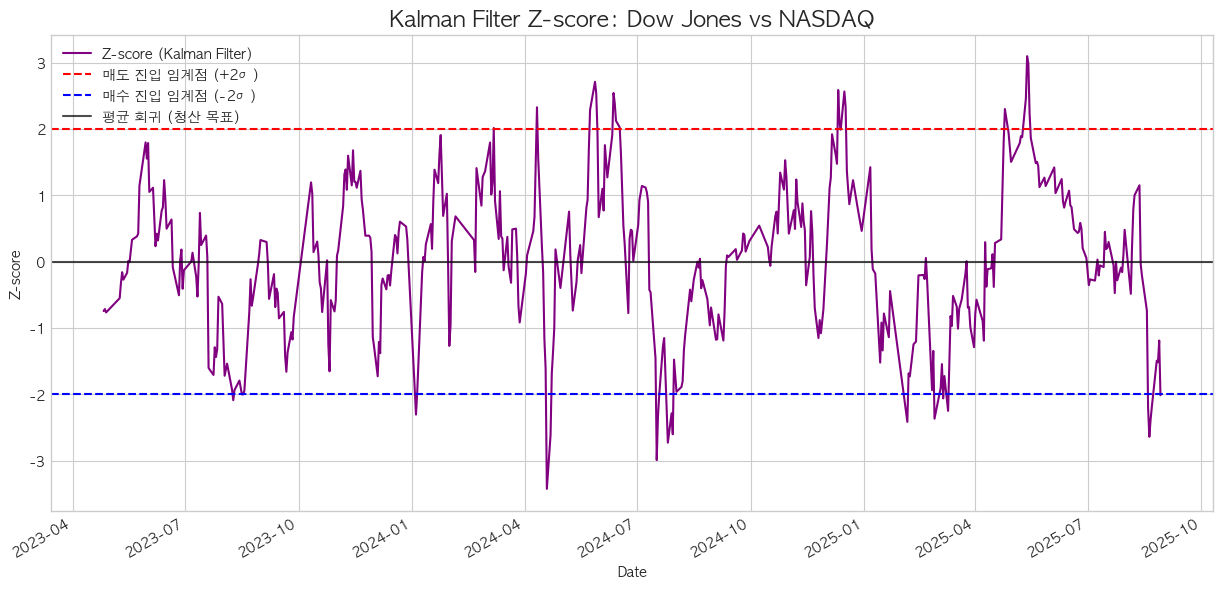


[2/2] 페어 분석: S&P 500 vs Dow Jones


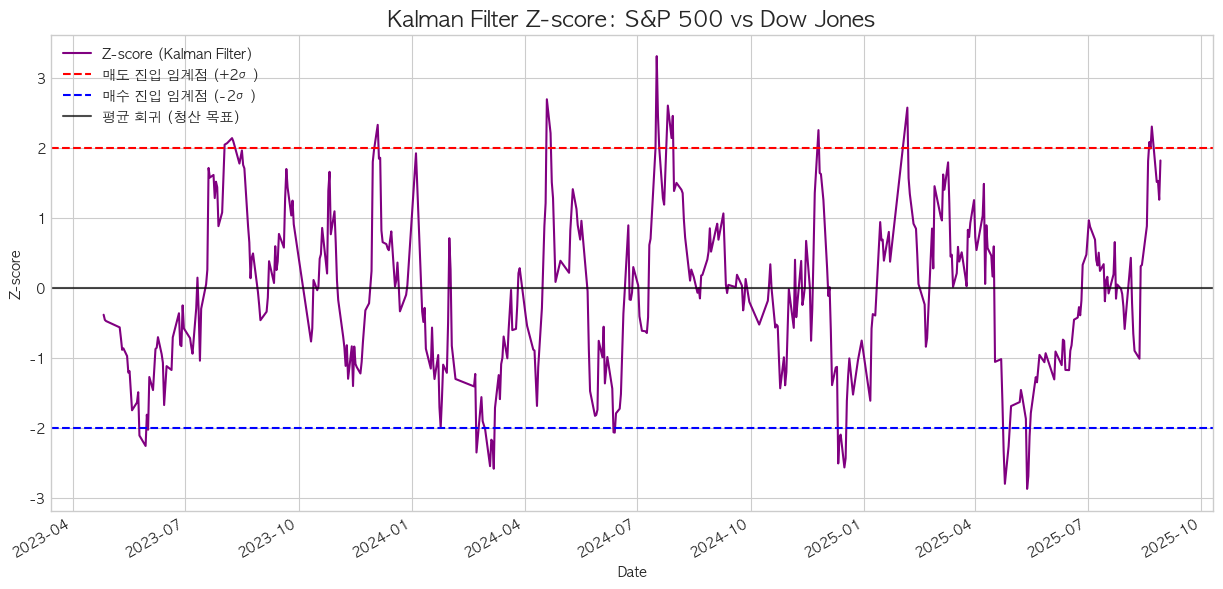

In [16]:
# -------------------------------------------
# 4. 칼만 필터를 이용한 심층 분석 및 시각화 (안정화 버전)
# -------------------------------------------
if 'KalmanFilter' in locals() and KalmanFilter is not None and 'all_intra_cluster_pairs' in locals() and all_intra_cluster_pairs:
    
    all_intra_cluster_pairs.sort(key=lambda x: x[2])
    
    print(f"\n✅ [칼만 필터] 총 {len(all_intra_cluster_pairs)}개 페어에 대한 심층 분석을 시작합니다.")
    
    for i, pair_info in enumerate(all_intra_cluster_pairs):
        
        pair_to_analyze = (pair_info[0], pair_info[1])
        
        print("\n" + "="*80)
        print(f"[{i+1}/{len(all_intra_cluster_pairs)}] 페어 분석: {pair_to_analyze[0]} vs {pair_to_analyze[1]}")
        print("="*80)

        try:
            S1 = prices_df[pair_to_analyze[0]]
            S2 = prices_df[pair_to_analyze[1]]

            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=0,
                initial_state_covariance=1,
                observation_covariance=1,
                transition_covariance=0.01
            )

            
            state_means, _ = kf.filter((S2 / S1).values)
            hedge_ratios_kf = pd.Series(state_means.flatten(), index=S1.index)

            # 동적 스프레드 및 Z-스코어 계산
            spread_kf = S2 - hedge_ratios_kf * S1
            
            window = 60 
            spread_mean_kf = spread_kf.rolling(window=window).mean()
            spread_std_kf = spread_kf.rolling(window=window).std()
            z_score_kf = (spread_kf - spread_mean_kf) / spread_std_kf

            # 시각화
            plt.figure(figsize=(15, 7))
            z_score_kf.plot(label='Z-score (Kalman Filter)', color='purple')
            plt.axhline(2.0, color='red', linestyle='--', label='매도 진입 임계점 (+2σ)')
            plt.axhline(-2.0, color='blue', linestyle='--', label='매수 진입 임계점 (-2σ)')
            plt.axhline(0, color='black', linestyle='-', alpha=0.7, label='평균 회귀 (청산 목표)')
            plt.title(f'Kalman Filter Z-score: {pair_to_analyze[0]} vs {pair_to_analyze[1]}', fontsize=16)
            plt.ylabel('Z-score')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"페어 {pair_to_analyze} 분석 중 오류 발생: {e}")
else:
    print("분석할 페어가 없음")